# This is implementation with pure Keras

### Has shuffling, normalisation, udf for model training, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [1]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K

# Loding data directly from Tensorflow

In [3]:
boston_housing = keras.datasets.boston_housing

In [4]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Analysing the data

The dataset contains 13 different features:

Per capita crime rate. - CRIM <br>
The proportion of residential land zoned for lots over 25,000 square feet. - ZN<br>
The proportion of non-retail business acres per town. - INDUS<br>
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). - CHAS<br>
Nitric oxides concentration (parts per 10 million). - NOX<br>
The average number of rooms per dwelling. - RM<br>
The proportion of owner-occupied units built before 1940. - AGE<br>
Weighted distances to five Boston employment centers. - DIS<br>
Index of accessibility to radial highways. - RAD<br>
Full-value property-tax rate per $10,000. - TAX<br>
Pupil-teacher ratio by town. - PTRATIO<br>
1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town. - B<br>
Percentage lower status of the population. - LSTAT<br>

In [5]:
# There are 12 features in the data
# 404 training rows
pd.DataFrame(train_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79


In [6]:
# 102 test rows
pd.DataFrame(test_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05
1,0.12329,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21
2,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74
3,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50
4,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29
98,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78
99,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92
100,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71


In [7]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


# Shuffle the training set

In [9]:
# argsort - Returns the indices that would sort an array.
# np.random.random - generate samples from the uniform distribution on [0, 1).
np.random.seed(0)
order = np.argsort(np.random.random(train_labels.shape))

In [10]:
train_data_shuff = train_data[order]
train_labels_shuff = train_labels[order]

# Visualising the data

## Features

In [11]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data_shuff, columns=column_names)

## Labels

In [12]:
df['price'] = pd.DataFrame(train_labels_shuff)

In [13]:
# The labels are the house prices in thousands of dollars
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
1,0.01432,100.0,1.32,0.0,0.411,6.816,40.5,8.3248,5.0,256.0,15.1,392.90,3.95,31.6
2,0.03306,0.0,5.19,0.0,0.515,6.059,37.3,4.8122,5.0,224.0,20.2,396.14,8.51,20.6
3,0.02543,55.0,3.78,0.0,0.484,6.696,56.4,5.7321,5.0,370.0,17.6,396.90,7.18,23.9
4,18.49820,0.0,18.10,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97,13.8


# Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation

In [14]:
# Test data is *not* used when calculating the mean and std.

# Calculating column wise mean and std
mean = train_data_shuff.mean(axis=0)
std = train_data_shuff.std(axis=0)

train_data_shuff = (train_data_shuff - mean) / std
test_data = (test_data - mean) / std

print(train_data_shuff[0])  # First training sample, normalized

[-0.40255104 -0.48361547 -1.31186211 -0.25683275 -0.84812434  0.22981568
 -0.36947682  1.14510462 -0.74135579 -1.10669897  0.10193124  0.41850097
 -1.03936976]


# Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [15]:
def build_model():
    model = Sequential()
    model.add(Dense(64,activation="relu",input_shape=(train_data_shuff.shape[1],)))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                    optimizer=RMSprop(lr=0.001),
                    metrics=[metrics.mae])
    print(model.summary())
    return model

# Train the model

In [32]:
def model_train(model, train_x, train_y, epochs=500, batch_size=100, valid_pct=0.2, early_stopping_rounds = 20, verbose=1):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
    
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_split=valid_pct, verbose=verbose,
                    callbacks=[early_stop])
    
    %matplotlib inline
    plot_history(history)
    
    [loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    print("Testing set Root Mean Sqd Error : {:7.2f}".format((loss ** 0.5)))
    
    return loss,mae

In [17]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0,5])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
None
Testing set Mean Abs Error:    2.52
Testing set Root Mean Sqd Error :    3.67


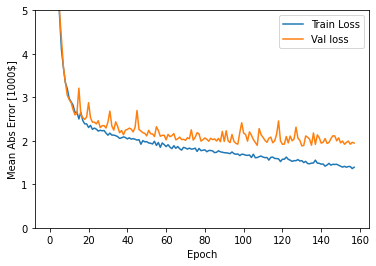

In [24]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v1.set_random_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

model = build_model()

loss,mae = model_train(model=model, train_x=train_data_shuff, train_y=train_labels_shuff, epochs=500, batch_size=16, valid_pct=0.2, early_stopping_rounds = 50, verbose=0)

# Predicting on the Test data

In [25]:
test_predictions = model.predict(test_data).flatten()

In [26]:
predictions = pd.DataFrame(index=range(len(test_labels)))
predictions['actual'] = pd.DataFrame(test_labels)
predictions['preds'] = pd.DataFrame(test_predictions)

In [27]:
predictions

,actual,preds
0,7.2,9.601399
1,18.8,17.881012
2,19.0,20.894268
3,27.0,34.388306
4,22.2,24.671375
...,...,...
97,21.9,40.081814
98,24.1,24.739845
99,50.0,44.750900
100,26.7,28.374475


In [28]:
# Mean and std of actual values in the test data.
predictions.actual.mean(), predictions.actual.std()

(23.07843137254902, 9.168862799704122)

In [29]:
# Percent error wrt to the mean actual price
print('Percent error: ',(loss ** 0.5)/predictions.actual.mean()*100,'%')

Percent error:  15.920779410590685 %


Text(0, 0.5, 'Predicted')

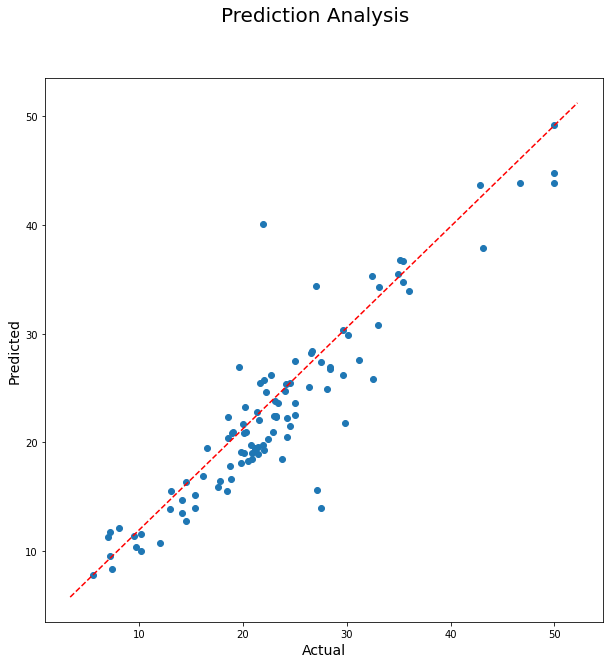

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)

# Conclusion

This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems). <br>
Similarly, evaluation metrics used for regression differ from classification. <br> 
A common regression metric is Mean Absolute Error (MAE).<br>
When input data features have values with different ranges, each feature should be scaled independently. <br>
If there is not much training data, prefer a small network with few hidden layers to avoid overfitting. <br>
Early stopping is a useful technique to prevent overfitting.<br>
